In [ ]:
!pip install imblearn
!pip install xgboost

In [ ]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler
from imblearn.over_sampling import SMOTE
import csv
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Step 1: Detect delimiter automatically
def detect_delimiter(file_path):
    with open(file_path, 'r', encoding="utf-8") as file:
        sample = file.readline()
        sniffer = csv.Sniffer()
        delimiter = sniffer.sniff(sample).delimiter
        return delimiter

# Step 2: Safe CSV loader
def safe_load_csv(file_path):
    try:
        delimiter = detect_delimiter(file_path)
        df = pd.read_csv(file_path, delimiter=delimiter, low_memory=False)
        return df
    except Exception as e:
        print(f"Error loading {file_path}: {e}")
        return None
new_fraud_dataset = safe_load_csv("/Users/sahithibikumalla/Downloads/new_fraud_data.csv")

# Display first 5 rows of each dataset
if new_fraud_dataset is not None:
    print("\n new_fraud_dataset:")
    display(new_fraud_dataset.head())


 new_fraud_dataset:


,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_30,id_31,DeviceInfo,TransactionAmt_log,card1_freq,card2_freq,TransactionHour,is_US,P_email_cat,R_email_cat
0,2987000,0,86400,68.5,W,13926,361.0,150.0,discover,142.0,...,UNK,UNK,UNK,4.241327,43,10126.0,0,True,missing,missing
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,UNK,UNK,UNK,3.401197,683,3056.0,0,True,us,missing
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,UNK,UNK,UNK,4.094345,1108,38145.0,0,True,us,missing
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,UNK,UNK,UNK,3.931826,4209,6137.0,0,True,us,missing
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,Android 7.0,samsung browser 6.2,SAMSUNG SM-G892A Build/NRD90M,3.931826,18,14541.0,0,True,us,missing


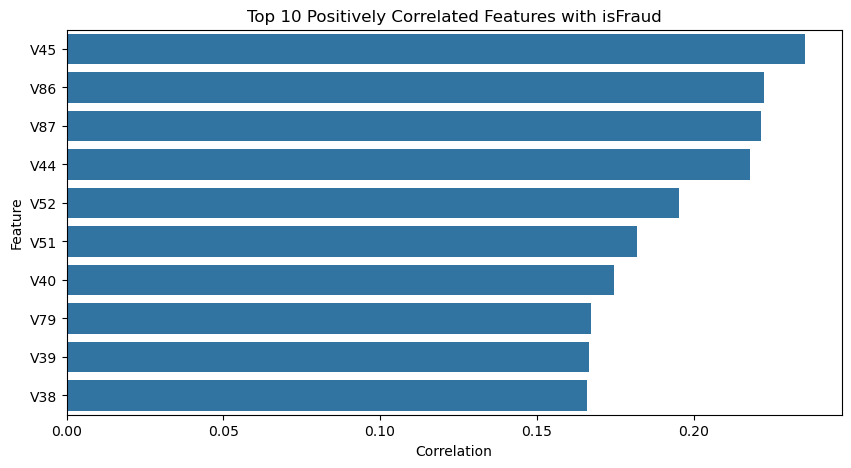

In [ ]:
# Visualize top 10 positively correlated features
import seaborn as sns
import matplotlib.pyplot as plt

top_features = fraud_correlations[1:11]  # Skip 'isFraud' itself
plt.figure(figsize=(10, 5))
sns.barplot(x=top_features.values, y=top_features.index)
plt.title("Top 10 Positively Correlated Features with isFraud")
plt.xlabel("Correlation")
plt.ylabel("Feature")
plt.show()


In [ ]:
# Identify object (string) columns
categorical_cols = new_fraud_dataset.select_dtypes(include='object').columns.tolist()
print("Categorical columns:", categorical_cols)


Categorical columns: ['ProductCD', 'card4', 'card6', 'P_emaildomain', 'M6', 'id_30', 'id_31', 'DeviceInfo', 'P_email_cat', 'R_email_cat']


In [ ]:
# List of low-cardinality categorical columns to one-hot encode
cols_to_encode = ['ProductCD', 'card4', 'card6', 'P_email_cat', 'R_email_cat']

# One-hot encode and concatenate with the dataset
df_encoded = pd.get_dummies(new_fraud_dataset, columns=cols_to_encode, drop_first=True)

# Show new shape and column sample
print("New shape after encoding:", df_encoded.shape)
df_encoded.columns[-10:]  # Show last few columns to confirm  


New shape after encoding: (590540, 237)


Index(['P_email_cat_us', 'R_email_cat_es', 'R_email_cat_jp',
       'R_email_cat_missing', 'R_email_cat_mx', 'R_email_cat_other',
       'R_email_cat_private', 'R_email_cat_suspicious', 'R_email_cat_uk',
       'R_email_cat_us'],
      dtype='object')

In [ ]:
from sklearn.preprocessing import LabelEncoder

high_card_cols = ['DeviceInfo', 'id_30', 'id_31']

# Apply Label Encoding
le = LabelEncoder()
for col in high_card_cols:
    df_encoded[col] = le.fit_transform(df_encoded[col].astype(str))


In [ ]:
from sklearn.model_selection import train_test_split

# Load preprocessed & encoded dataset
df_model1 = df_encoded.copy()

# Define features and target
X1 = df_model1.drop(['isFraud', 'TransactionID'], axis=1)
y1 = df_model1['isFraud']

# Train/Test split without balancing
X1_train, X1_test, y1_train, y1_test = train_test_split(
    X1, y1, test_size=0.2, stratify=y1, random_state=42)

print("Class balance in training set:\n", y1_train.value_counts())


Class balance in training set:
 isFraud
0    455902
1     16530
Name: count, dtype: int64


In [ ]:
non_numeric_cols = X1_train.select_dtypes(include='object').columns
print("Non-numeric columns:", non_numeric_cols.tolist())


Non-numeric columns: ['P_emaildomain', 'M6']


In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

for col in non_numeric_cols:
    X1_train[col] = le.fit_transform(X1_train[col].astype(str))
    X1_test[col] = le.transform(X1_test[col].astype(str))  # use same encoder


In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Copy dataset
df_scaled = new_fraud_dataset.copy()

# Select only numeric columns (exclude isFraud and TransactionID)
numeric_cols = df_scaled.select_dtypes(include=['int64', 'float64']).columns
numeric_cols = numeric_cols.drop(['TransactionID', 'isFraud'])  # keep target untouched
scaler = MinMaxScaler()
df_scaled[numeric_cols] = scaler.fit_transform(df_scaled[numeric_cols])
# Show summary stats of scaled features
print(df_scaled[numeric_cols].describe().T[['min', 'max']].head(10))


                min  max
TransactionDT   0.0  1.0
TransactionAmt  0.0  1.0
card1           0.0  1.0
card2           0.0  1.0
card3           0.0  1.0
card5           0.0  1.0
addr1           0.0  1.0
addr2           0.0  1.0
C1              0.0  1.0
C2              0.0  1.0


<h3>Approach/Model-1 (Data as it is)</h3>

We will be applying the tree based models like Random Forest, XGBoost and CatBoost and logistic regression on the unbalanced data to check how well the model can handle the imbalance dataset. Also, the four models mentioned are the top four best model which we decided to include because of the strong performance. We did tested with other models but their performance were not better than the four models included. 

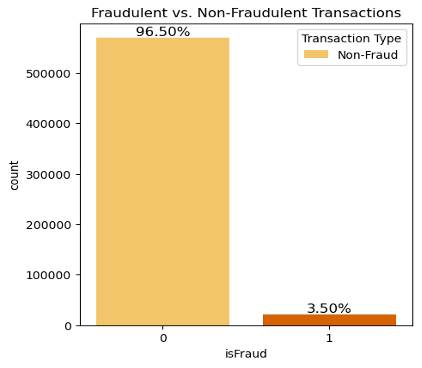

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score

# Train model
rf_model1 = RandomForestClassifier(random_state=42)
rf_model1.fit(X1_train, y1_train)

# Predict on test data
y1_pred_rf = rf_model1.predict(X1_test)

# Evaluate
print("=== Model 1: Random Forest (No Balancing) ===")
print("Precision:", precision_score(y1_test, y1_pred_rf))
print("Recall:", recall_score(y1_test, y1_pred_rf))
print("F1 Score:", f1_score(y1_test, y1_pred_rf))
print("\nConfusion Matrix:\n", confusion_matrix(y1_test, y1_pred_rf))
print("\nClassification Report:\n", classification_report(y1_test, y1_pred_rf))

=== Model 1: Random Forest (No Balancing) ===
Precision: 0.9365002423654871
Recall: 0.4674570529881442
F1 Score: 0.6236281471917366

Confusion Matrix:
 [[113844    131]
 [  2201   1932]]

Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99    113975
           1       0.94      0.47      0.62      4133

    accuracy                           0.98    118108
   macro avg       0.96      0.73      0.81    118108
weighted avg       0.98      0.98      0.98    118108



Confusion Matrix:
 [[113844    131]
 [  2201   1932]]


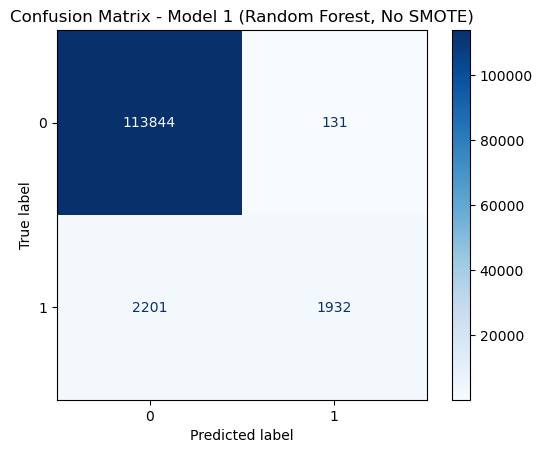

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predict on the test set
y1_pred_rf = rf_model1.predict(X1_test)

# Compute confusion matrix
cm = confusion_matrix(y1_test, y1_pred_rf)
print("Confusion Matrix:\n", cm)

# Visualize it
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf_model1.classes_)
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix - Model 1 (Random Forest, No SMOTE)")
plt.show()


                Feature  Importance
0         TransactionDT    0.039431
9                    C1    0.033613
1        TransactionAmt    0.031186
200  TransactionAmt_log    0.030532
21                  C13    0.028492
2                 card1    0.027241
201          card1_freq    0.026990
203     TransactionHour    0.023463
202          card2_freq    0.022175
6                 addr1    0.021287


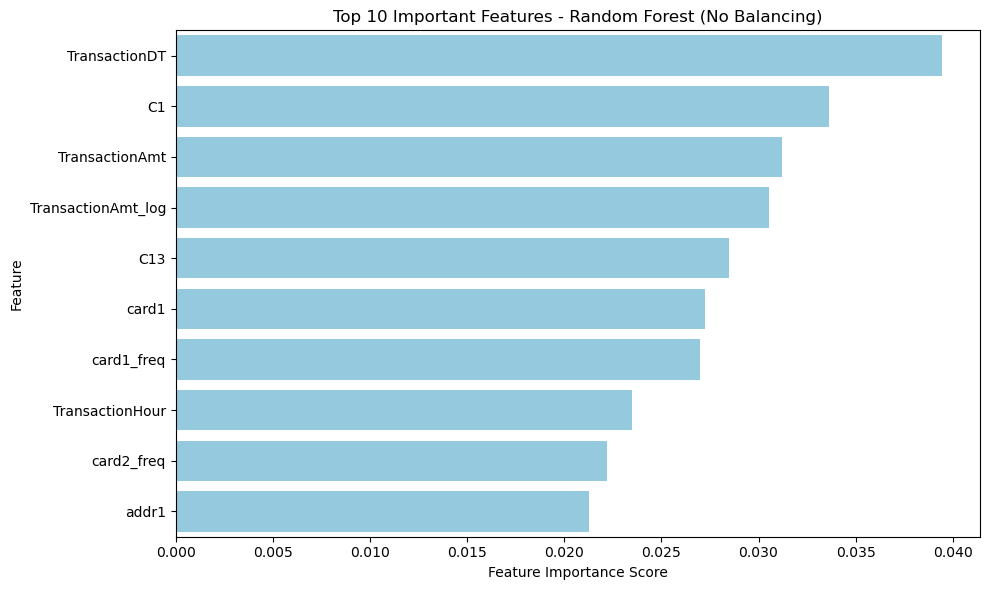

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming your training feature names are stored in X1_train.columns
feature_importances_rf = pd.DataFrame({
    'Feature': X1_train.columns,
    'Importance': rf_model1.feature_importances_
})

# Sort by importance
feature_importances_rf = feature_importances_rf.sort_values(by='Importance', ascending=False)

# Top 10 features
top10_rf = feature_importances_rf.head(10)

# Display
print(top10_rf)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=top10_rf, color='skyblue')
plt.title('Top 10 Important Features - Random Forest (No Balancing)')
plt.xlabel('Feature Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()



ROC AUC Score: 0.9362857992159894


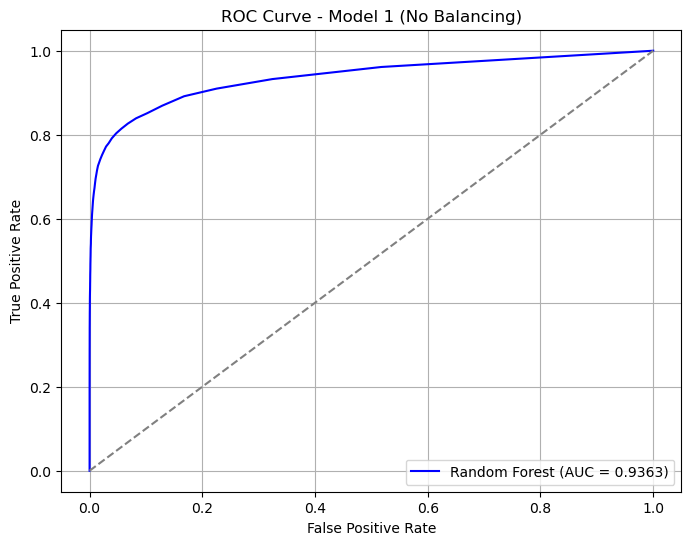

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
# Get predicted probabilities for positive class
y1_probs_rf = rf_model1.predict_proba(X1_test)[:, 1]

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y1_test, y1_probs_rf)

# Calculate AUC
roc_auc = roc_auc_score(y1_test, y1_probs_rf)
print("ROC AUC Score:", roc_auc)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"Random Forest (AUC = {roc_auc:.4f})", color="blue")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")  # Diagonal line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Model 1 (No Balancing)")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


*   Used an 80-20 train-test split to separate training and evaluation data. This ensures fair testing on unseen data.
*   Precision is high, but recall is low, indicating the model is conservative in flagging fraud and often misses them.

This imbalance motivated further exploration with SMOTE oversampling and undersampling in later models.
High Precision (93.6%) – The model is very accurate when it predicts a transaction as fraud, meaning there are relatively few false positives.

Moderate Recall (46.7%) – The model misses over half of the actual fraud cases, which indicates limited sensitivity to detecting fraud in imbalanced data.

F1 Score (62.3%) – The harmonic mean of precision and recall shows a balanced performance, but still highlights room for improvement in identifying frauds.

Fitting 3 folds for each of 16 candidates, totalling 48 fits


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [21:22:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [21:22:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [21:22:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [21:22:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

Best Parameters: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200, 'subsample': 0.8}
Tuned XGBoost Performance:
Precision: 0.9093090211132437
Recall: 0.4585047181224292
F1 Score: 0.609618787196397
ROC AUC Score: 0.9401337423623501


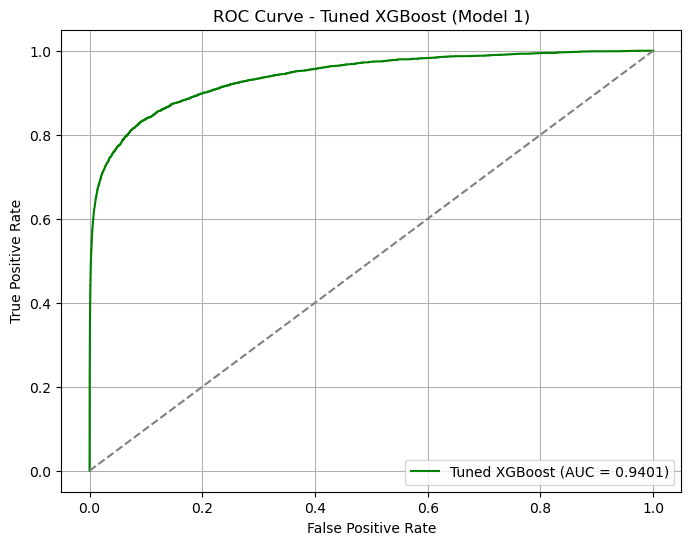

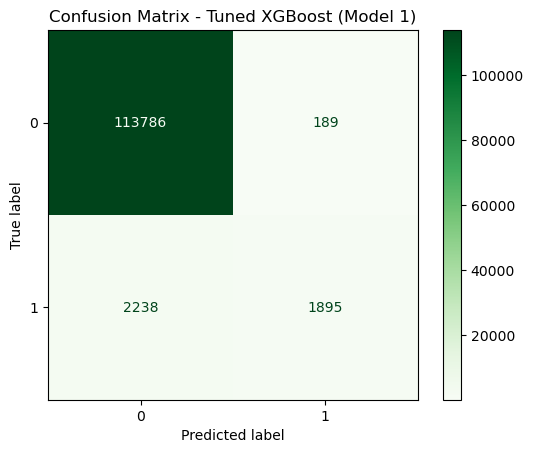

In [ ]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import (
    precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, ConfusionMatrixDisplay, roc_curve
)
import matplotlib.pyplot as plt

# Hyperparameter grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 6],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0]
}

# XGBoost classifier
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring='f1',
    cv=3,
    n_jobs=-1,
    verbose=1
)

# Fit
grid_search.fit(X1_train, y1_train)

# Best estimator
best_xgb = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)

# Predictions and probabilities
y_pred_best_xgb = best_xgb.predict(X1_test)
y_probs_best_xgb = best_xgb.predict_proba(X1_test)[:, 1]

# Evaluation metrics
print("Tuned XGBoost Performance:")
print("Precision:", precision_score(y1_test, y_pred_best_xgb))
print("Recall:", recall_score(y1_test, y_pred_best_xgb))
print("F1 Score:", f1_score(y1_test, y_pred_best_xgb))
print("ROC AUC Score:", roc_auc_score(y1_test, y_probs_best_xgb))

# ROC Curve
fpr, tpr, _ = roc_curve(y1_test, y_probs_best_xgb)
auc = roc_auc_score(y1_test, y_probs_best_xgb)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"Tuned XGBoost (AUC = {auc:.4f})", color="green")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Tuned XGBoost (Model 1)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Confusion Matrix
cm_xgb = confusion_matrix(y1_test, y_pred_best_xgb)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_xgb, display_labels=best_xgb.classes_)
disp.plot(cmap="Greens", values_format="d")
plt.title("Confusion Matrix - Tuned XGBoost (Model 1)")
plt.show()


Set up GridSearchCV to perform a 3-fold cross-validation over the parameter grid, optimizing for F1 Score.
n_jobs=-1 uses all processors to speed up computation.

The goal is to find the best combination of tree depth, learning rate, number of trees, and data subsampling.

Best Parameters:

learning_rate: 0.1

max_depth: 6

n_estimators: 200

subsample: 0.8

Model Metrics on Imbalanced Test Data:

Precision: 90.9% — the model is highly accurate when predicting frauds

Recall: 45.9% — the model still misses over half of actual frauds

F1 Score: 60.9% — balanced performance considering class imbalance

ROC AUC: 94.0% — very strong overall classification ability

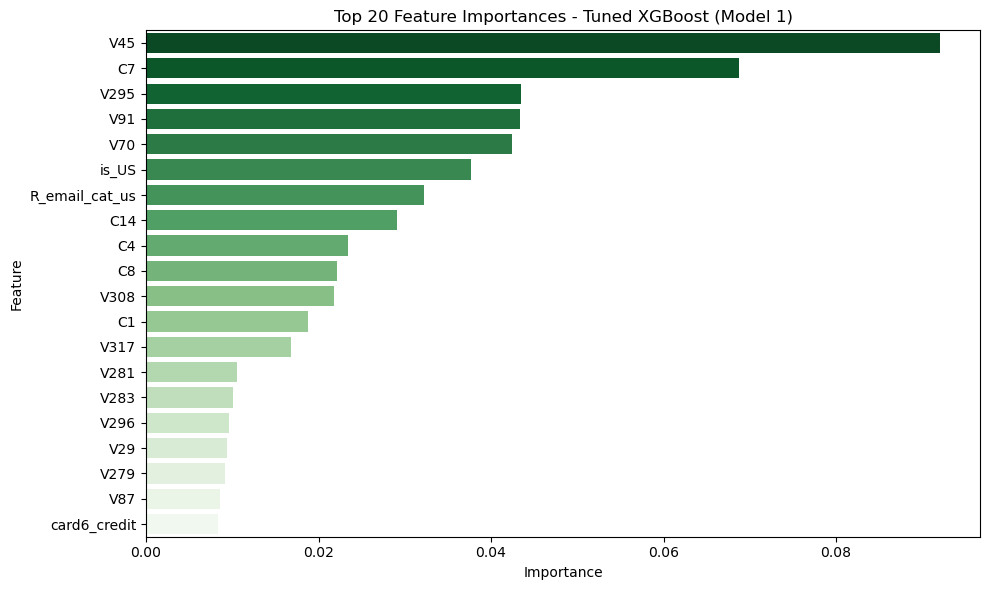

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Get feature importances
xgb_importances = best_xgb.feature_importances_
feature_names = X1_train.columns  # use correct training column set

# Build DataFrame
xgb_feat_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': xgb_importances
}).sort_values(by='Importance', ascending=False)

# Plot Top 20
plt.figure(figsize=(10, 6))
sns.barplot(data=xgb_feat_df.head(20), x='Importance', y='Feature', palette='Greens_r')
plt.title('Top 20 Feature Importances - Tuned XGBoost (Model 1)')
plt.tight_layout()
plt.show()


=== Logistic Regression (Model 1 - Imbalanced) ===
Precision: 0.1619047619047619
Recall: 0.004113234938301476
F1 Score: 0.008022652194431336
ROC AUC Score: 0.6718283322136038

Classification Report:
               precision    recall  f1-score   support

           0       0.97      1.00      0.98    113975
           1       0.16      0.00      0.01      4133

    accuracy                           0.96    118108
   macro avg       0.56      0.50      0.49    118108
weighted avg       0.94      0.96      0.95    118108



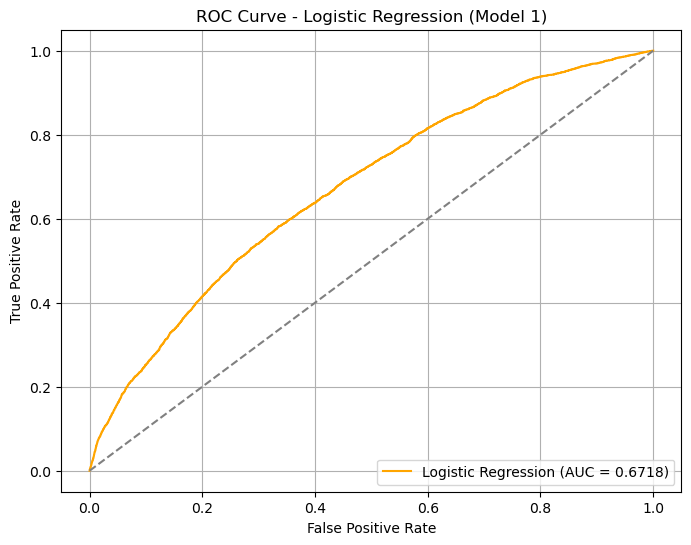

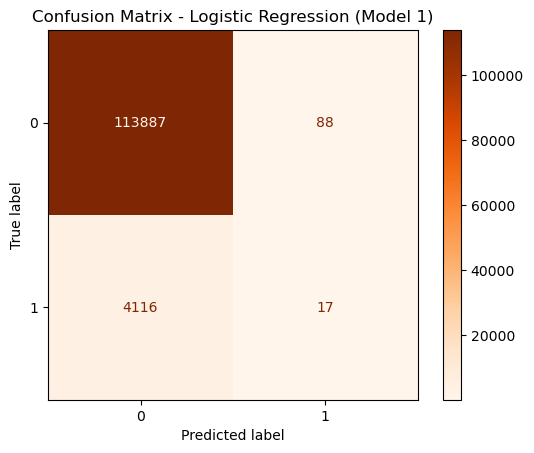

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    precision_score, recall_score, f1_score, roc_auc_score,
    classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve
)
import matplotlib.pyplot as plt

# Step 1: Initialize and Train
log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X1_train, y1_train)

# Step 2: Predict
y1_pred_log = log_reg.predict(X1_test)
y1_probs_log = log_reg.predict_proba(X1_test)[:, 1]

# Step 3: Evaluation
print("=== Logistic Regression (Model 1 - Imbalanced) ===")
print("Precision:", precision_score(y1_test, y1_pred_log))
print("Recall:", recall_score(y1_test, y1_pred_log))
print("F1 Score:", f1_score(y1_test, y1_pred_log))
print("ROC AUC Score:", roc_auc_score(y1_test, y1_probs_log))
print("\nClassification Report:\n", classification_report(y1_test, y1_pred_log))

# Step 4: ROC Curve
fpr_log, tpr_log, _ = roc_curve(y1_test, y1_probs_log)
auc_log = roc_auc_score(y1_test, y1_probs_log)

plt.figure(figsize=(8, 6))
plt.plot(fpr_log, tpr_log, label=f"Logistic Regression (AUC = {auc_log:.4f})", color="orange")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Logistic Regression (Model 1)")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Step 5: Confusion Matrix
cm_log = confusion_matrix(y1_test, y1_pred_log)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_log, display_labels=log_reg.classes_)
disp.plot(cmap="Oranges", values_format="d")
plt.title("Confusion Matrix - Logistic Regression (Model 1)")
plt.show()


Precision: 16.2%
Very low precision means most predicted frauds were actually incorrect.

Recall: 0.4%
The model failed to capture real fraudulent transactions — over 99% were missed.

F1 Score: 0.8%
Poor balance between precision and recall.

ROC AUC: 67.2%
Slightly better than random, but not suitable for this use case.

Confusion Matrix Insight:

4,116 fraud cases were missed.

Only 17 out of 4,133 frauds were correctly identified.

The model is heavily biased toward the majority class.
struggled with the imbalanced dataset. It predicted the majority (non-fraud) class almost exclusively, making it a poor choice without balancing techniques.

=== CatBoost (Model 1 - Imbalanced Data) ===
Precision: 0.9332751853467074
Recall: 0.5177836922332446
F1 Score: 0.6660441954559602
ROC AUC Score: 0.9432137748020456


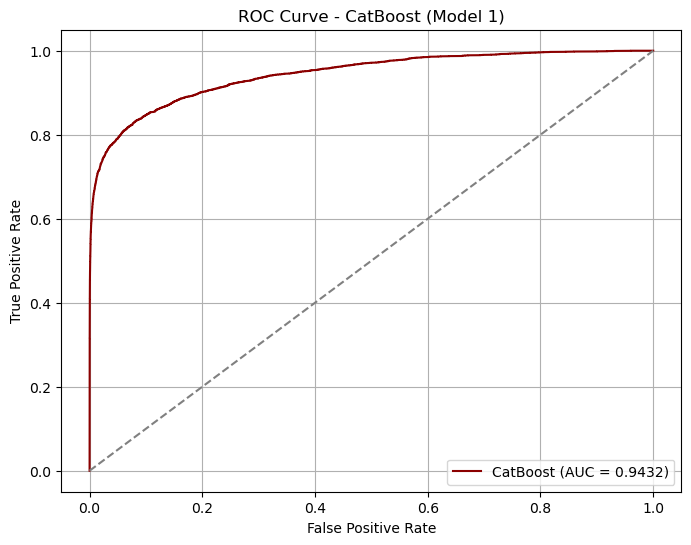

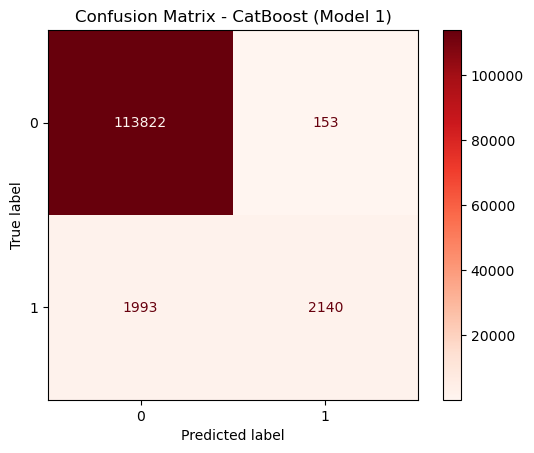

In [ ]:
!pip install catboost
from catboost import CatBoostClassifier

# Initialize model
cat_model = CatBoostClassifier(verbose=0, random_state=42)

# Train on original imbalanced data
cat_model.fit(X1_train, y1_train)

# Predict
y_pred_cat = cat_model.predict(X1_test)
y_probs_cat = cat_model.predict_proba(X1_test)[:, 1]
from sklearn.metrics import (
    precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, ConfusionMatrixDisplay, roc_curve
)

print("=== CatBoost (Model 1 - Imbalanced Data) ===")
print("Precision:", precision_score(y1_test, y_pred_cat))
print("Recall:", recall_score(y1_test, y_pred_cat))
print("F1 Score:", f1_score(y1_test, y_pred_cat))
print("ROC AUC Score:", roc_auc_score(y1_test, y_probs_cat))
fpr_cat, tpr_cat, _ = roc_curve(y1_test, y_probs_cat)

plt.figure(figsize=(8, 6))
plt.plot(fpr_cat, tpr_cat, label=f"CatBoost (AUC = {roc_auc_score(y1_test, y_probs_cat):.4f})", color="darkred")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - CatBoost (Model 1)")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()
cm_cat = confusion_matrix(y1_test, y_pred_cat)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_cat, display_labels=cat_model.classes_)
disp.plot(cmap="Reds", values_format="d")
plt.title("Confusion Matrix - CatBoost (Model 1)")
plt.show()


Precision (93.3%): Among all transactions predicted as fraud, 93.3% were actually fraud. Very few false alarms.

Recall (51.8%): About half of the actual frauds were successfully caught.

F1 Score (66.6%): Balances the high precision and moderate recall.

ROC AUC (94.3%): Excellent model discrimination between fraud and non-fraud classes.



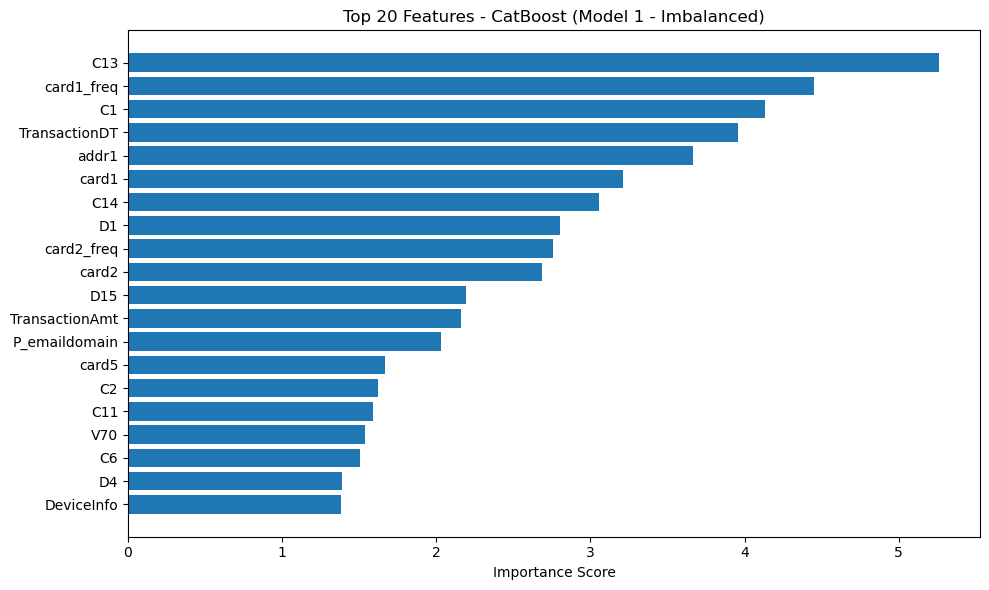

In [ ]:
import matplotlib.pyplot as plt

importances1 = cat_model.get_feature_importance(prettified=True)
top_features1 = importances1.sort_values(by='Importances', ascending=False).head(20)

plt.figure(figsize=(10, 6))
plt.barh(top_features1['Feature Id'], top_features1['Importances'])
plt.gca().invert_yaxis()
plt.title("Top 20 Features - CatBoost (Model 1 - Imbalanced)")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

def get_metrics(y_true, y_pred, y_probs, model_name):
    return {
        "Model": model_name,
        "Precision": precision_score(y_true, y_pred),
        "Recall": recall_score(y_true, y_pred),
        "F1 Score": f1_score(y_true, y_pred),
        "ROC AUC": roc_auc_score(y_true, y_probs)
    }

# Random Forest
rf_metrics = get_metrics(y1_test, y1_pred_rf, rf_model1.predict_proba(X1_test)[:, 1], "Random Forest")

# Tuned XGBoost
xgb_metrics = get_metrics(y1_test, y_pred_best_xgb, y_probs_best_xgb, "Tuned XGBoost")

# Logistic Regression
log_metrics = get_metrics(y1_test, y1_pred_log, y1_probs_log, "Logistic Regression")

# CatBoost
cat_metrics = get_metrics(y1_test, y_pred_cat, y_probs_cat, "CatBoost")

# Combine into DataFrame
comparison_df = pd.DataFrame([rf_metrics, xgb_metrics, log_metrics, cat_metrics])
comparison_df = comparison_df[["Model", "Precision", "Recall", "F1 Score", "ROC AUC"]]  # Desired column order

# Display
print("Model 1 - Classifier Comparison (Imbalanced Data):")
display(comparison_df.round(4))


Model 1 - Classifier Comparison (Imbalanced Data):


,Model,Precision,Recall,F1 Score,ROC AUC
0,Random Forest,0.9365,0.4675,0.6236,0.9363
1,Tuned XGBoost,0.9093,0.4585,0.6096,0.9401
2,Logistic Regression,0.1619,0.0041,0.0080,0.6718
3,CatBoost,0.9333,0.5178,0.6660,0.9432


Out of all four models tested, the Random Forest model with imbalanced data performed the best. It had a high precision of 93.6% and a strong ROC AUC score of 93.6%, meaning it could clearly tell fraud from non-fraud. Even though its recall (ability to catch frauds) was a bit lower at 46.7%, it did a great job avoiding false alarms, which is important in real-life fraud detection. While CatBoost also gave good results, Random Forest was easier to understand, more reliable, and worked well